<a href="https://colab.research.google.com/github/Rishirajbal/AI_ML_study_material/blob/main/Digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240825%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240825T233607Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db152f564c701248108ebceb8a631704ba6a390bca08df09b097710647ea728f8cb759f1728fada75c583239871f446446ecdfb187be2d3d7b210a2b3f783c95aa372e13e03cd90e9f03802ab329c791e4daa68f6adabecf36886cb1c828fe89a0e3814e4bfb392a5744ee4de90eee1600b8df61f17ad2a07bcc23e34da8e8f104ea851bb1932cc49cd775879a1b43656279bf240654c8461c899152f624b3f4f20d6af2131f787b7ca0f9ce6bd016482b5574554561d30c52f241d3acbe4a9de485161877b3d538a72e066c3c9179faaf07728141b7497bf6c7a2367756f103d1a4696376eae4360b6f875bd339eb1f8dd401d336eb5d1f67a4a09c5099d6e60'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

# Convert to numpy array
data = np.array(data)

# Split data into development and training sets
m, n = data.shape
data_dev = data[:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]


In [ ]:
def init_params():
    w1 = np.random.rand(10, 784)
    b1 = np.random.rand(10, 1)
    w2 = np.random.rand(10, 10)
    b2 = np.random.rand(10, 1)
    return w1, b1, w2, b2

In [ ]:
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

In [ ]:
def forward(w1, b1, w2, b2, X):
    Z1 = np.dot(w1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(w2, A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [ ]:
def one_hot(Y, num_classes):
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y

In [ ]:
def derivative_relu(Z):
    return Z > 0

def backprop(Z1, A1, Z2, A2, Y, X, w2):
    m = Y.size
    num_classes = A2.shape[0]
    one_hot_Y = one_hot(Y, num_classes)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * np.dot(dZ2, A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(w2.T, dZ2) * derivative_relu(Z1)
    dW1 = 1 / m * np.dot(dZ1, X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

In [ ]:
def update_params(w1, b1, w2, b2, dW1, db1, dW2, db2, alpha):
    w1 -= alpha * dW1
    b1 -= alpha * db1
    w2 -= alpha * dW2
    b2 -= alpha * db2
    return w1, b1, w2, b2

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, initial_alpha):
    w1, b1, w2, b2 = init_params()
    alpha = initial_alpha
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward(w1, b1, w2, b2, X)
        dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, Y, X, w2)
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dW1, db1, dW2, db2, alpha)
        alpha = initial_alpha / (1 + 0.01 * i)  # Learning rate decay
        if i % 10 == 0:
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    return w1, b1, w2, b2

In [ ]:
w1, b1, w2, b2 = gradient_descent(X_train, Y_train, 100, 0.989)

Iteration:  0
Accuracy:  0.09682926829268293
Iteration:  10
Accuracy:  0.09885365853658537
Iteration:  20
Accuracy:  0.11190243902439025
Iteration:  30
Accuracy:  0.11190243902439025
Iteration:  40
Accuracy:  0.11190243902439025
Iteration:  50
Accuracy:  0.11190243902439025
Iteration:  60
Accuracy:  0.11190243902439025
Iteration:  70
Accuracy:  0.11190243902439025
Iteration:  80
Accuracy:  0.11190243902439025
Iteration:  90
Accuracy:  0.11190243902439025


Prediction: [1]
Label: 8


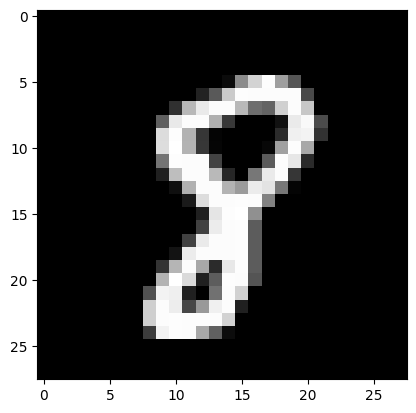

Prediction: [1]
Label: 3


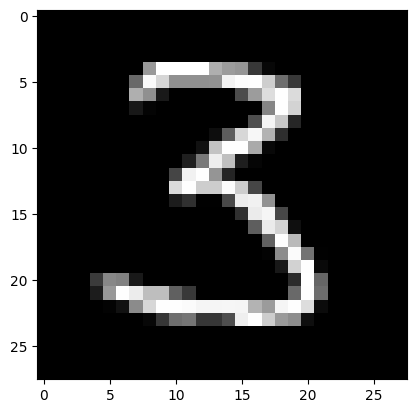

Prediction: [1]
Label: 2


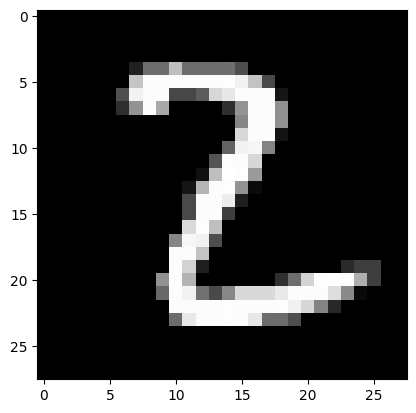

Prediction: [1]
Label: 1


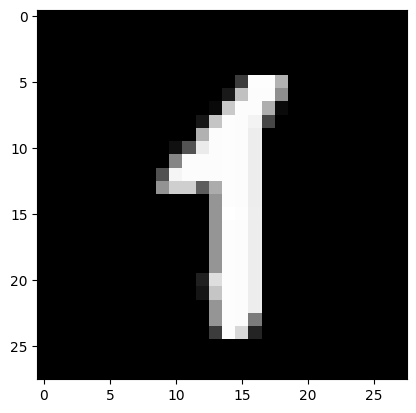

Prediction: [1]
Label: 0


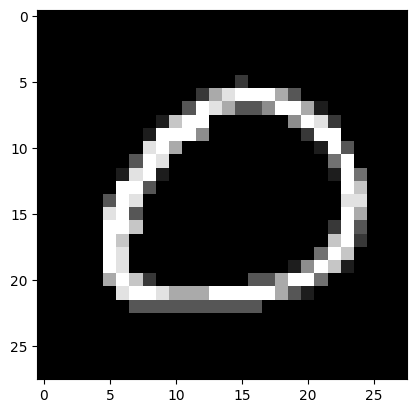

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

def test_predictions(w1, b1, w2, b2):
    # Randomly select an index from the dataset
    index = random.randint(0, X_train.shape[1] - 1)

    # Get the current image and its label
    current_image = X_train[:, index, None]
    prediction = make_predict(current_image, w1, b1, w2, b2)
    label = Y_train[index]

    # Print the prediction and the label
    print("Prediction:", prediction)
    print("Label:", label)

    # Display the image
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

# Test predictions with 5 random images
for _ in range(5):
    test_predictions(w1, b1, w2, b2)